# Feature engineering

**Goal:** first work on the classifier
  
This notebook is divided in two parts:
* **1. Bla**

In [80]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [4]:
# model_RF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
#                          RandomForestClassifier(random_state=42, criterion='entropy', max_depth=20, n_estimators=500))

## Get the data

In [108]:
%run ../impact_wrapper.py
data = Impact_Wrapper('../../../data/annotated_final_IMPACT_mutations_180508.txt', 'is_artefact')

In [106]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_SYMBOL', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'somatic-driver': ['VEP_COSMIC_CNT',
                       'is_a_hotspot', 'is_a_3d_hotspot', 'oncogenic'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'Kaviar_AF', 'VEP_in_dbSNP'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = unlist([group for key, group in features_groups.items() if key not in groups_to_remove])
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove unique values
    return list(set(final_selection))

## Baseline

In [109]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_baseline = Selene_Job('fe_baseline', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job_baseline.load_data(X, y)

In [115]:
job_baseline = Selene_Job('fe_baseline', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_baseline >: </span>✅ job found and reloaded

In [116]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500))
metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ../ssh_remote_jobs/job_fe_baseline/script.ipy


In [9]:
job_baseline.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1493   187.4KB/s   00:00    
metrics.pkl                                   100%   64MB  15.9MB/s   00:04    
script.ipy                                    100%  828    51.3KB/s   00:00    
X.pkl                                         100%   64MB  10.7MB/s   00:05    
y.pkl                                         100% 3225KB  10.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_baseline
Job <28977468> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_baseline -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_baseline >: </span>✅ submitted<br>

In [118]:
job_baseline.get_results()

<span style="color:green">Job < fe_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_baseline to ../ssh_remote_jobs/job_fe_baseline
metrics.pkl                                   100%   64MB   8.5MB/s   00:07    
job_output.txt                                100% 1492    23.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.603 ± 0.012
▴ Mean roc_auc          : 0.909 ± 0.004
▴ Mean precision        : 0.206 ± 0.005
▴ Mean recall           : 0.786 ± 0.012
▴ Mean f1               : 0.326 ± 0.006
▴ Mean accuracy         : 0.880 ± 0.003


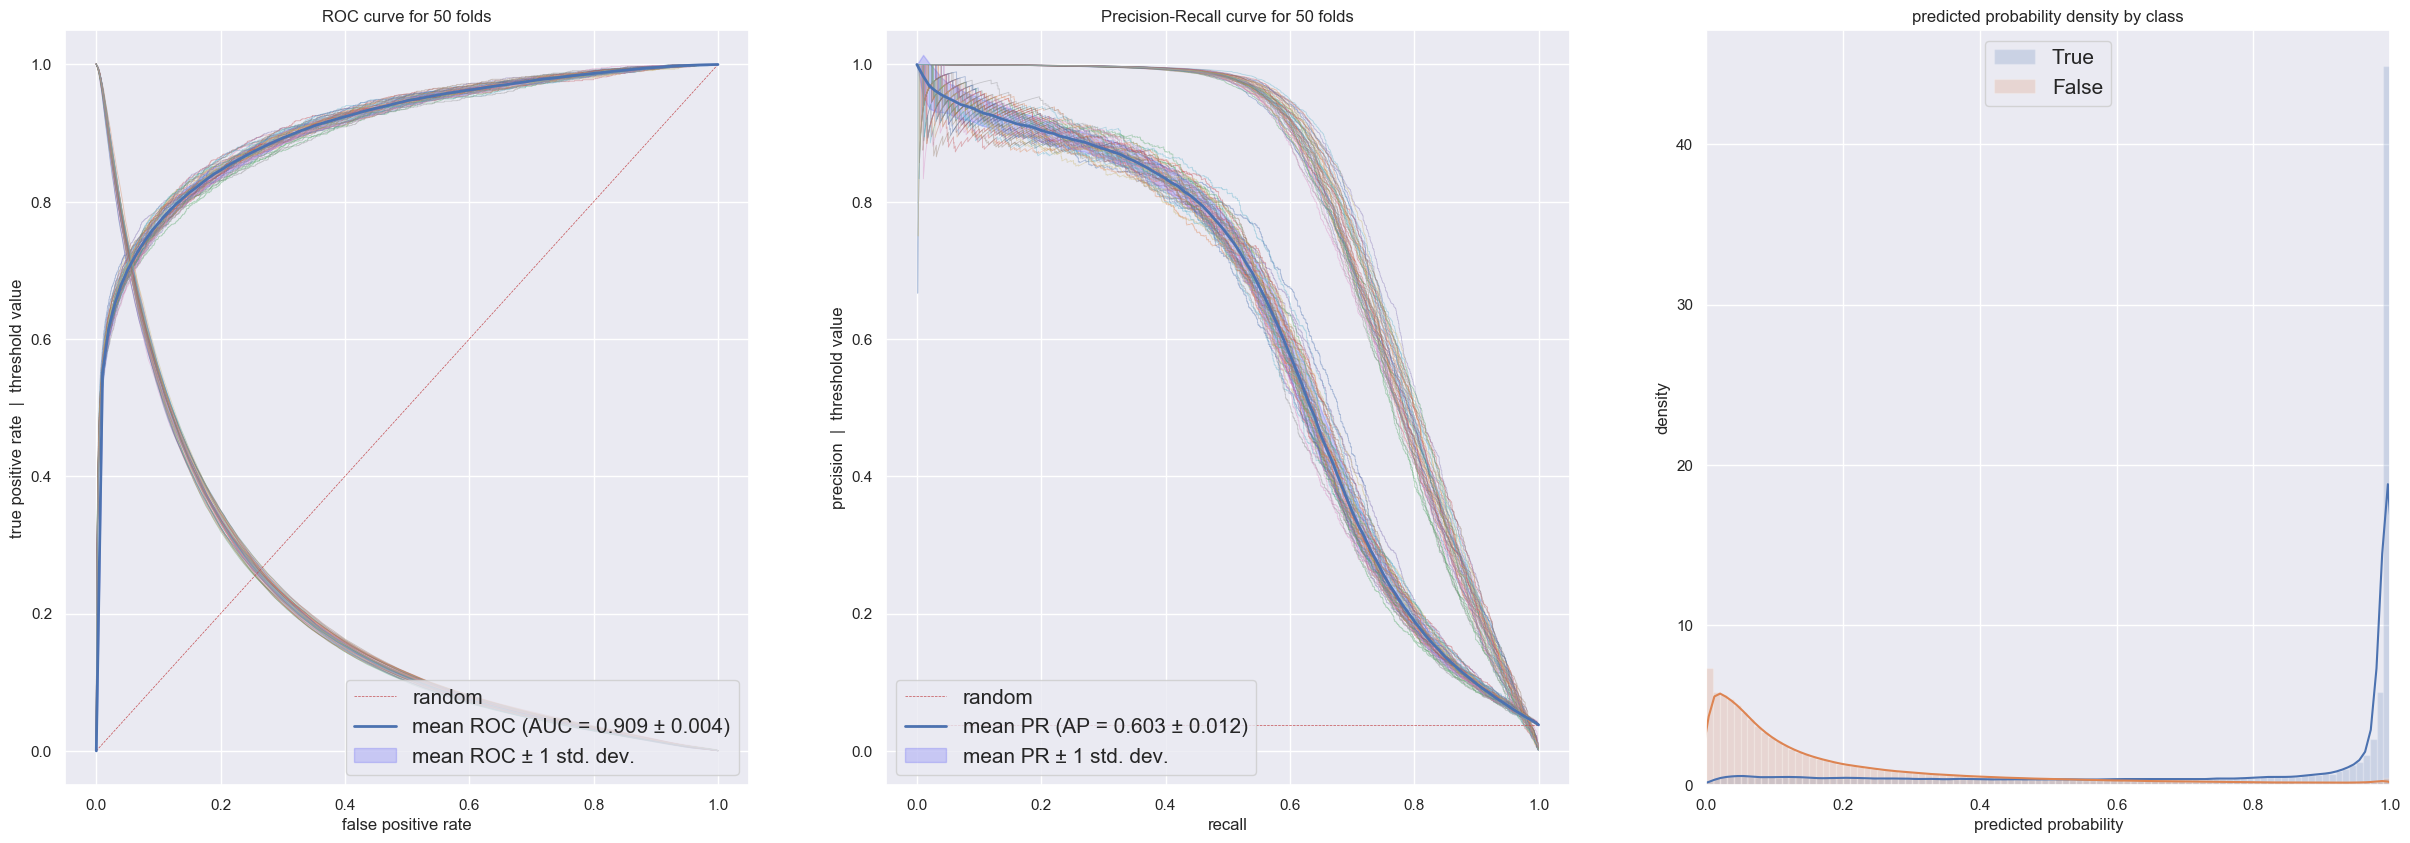

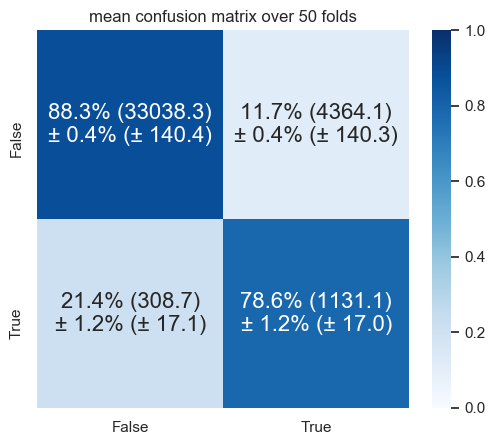

In [119]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

## Removing one group

In [12]:
job_list = {}

for group in features_groups.keys():
    name = 'without_{}'.format(group)
    print_md('**{}**'.format(name))
    
    job_list[name] = Selene_Job('fe_{}'.format(name), 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
    
    # get X and y
    print('Get X and y...', end= '')
    start = time.time()
    features = get_features(groups_to_remove = [group], individual_features_to_remove = ['VEP_SYMBOL'])
    X, y = data.process(features).get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    # prepare job
    job_list[name].load_data(X, y, path_to_script=job_baseline.script_path)

**without_NGS**

<span style="color:red">Job < fe_without_NGS >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (8.48s, 25 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_NGS


<span style="color:green">Job < fe_without_NGS >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_NGS


<span style="color:green">Job < fe_without_NGS >: </span>✅ script loaded

**without_genome**

<span style="color:red">Job < fe_without_genome >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (7.52s, 34 raw features, 63 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_genome


<span style="color:green">Job < fe_without_genome >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_genome


<span style="color:green">Job < fe_without_genome >: </span>✅ script loaded

**without_freq**

<span style="color:red">Job < fe_without_freq >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (9.52s, 35 raw features, 90 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_freq


<span style="color:green">Job < fe_without_freq >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_freq


<span style="color:green">Job < fe_without_freq >: </span>✅ script loaded

**without_somatic-driver**

<span style="color:red">Job < fe_without_somatic-driver >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (7.18s, 32 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_somatic-driver


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_somatic-driver


<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ script loaded

**without_consequence**

<span style="color:red">Job < fe_without_consequence >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (5.16s, 30 raw features, 64 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_consequence


<span style="color:green">Job < fe_without_consequence >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_consequence


<span style="color:green">Job < fe_without_consequence >: </span>✅ script loaded

**without_AF**

<span style="color:red">Job < fe_without_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (8.58s, 24 raw features, 78 features after processing)
➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_AF


<span style="color:green">Job < fe_without_AF >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_AF


<span style="color:green">Job < fe_without_AF >: </span>✅ script loaded

In [121]:
job_list = {}
for group in features_groups.keys():
    name = 'without_{}'.format(group)
    job_list[name] = Selene_Job('fe_{}'.format(name), 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id='True')

<span style="color:green">Job < fe_without_NGS >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_genome >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_freq >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_consequence >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_without_AF >: </span>✅ job found and reloaded

In [123]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.run(n_jobs=20, short_job=True)

**fe_without_NGS**

**fe_without_genome**

**fe_without_freq**

**fe_without_somatic-driver**

**fe_without_consequence**

**fe_without_AF**

In [124]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.get_results()

**fe_without_NGS**

<span style="color:green">Job < fe_without_NGS >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_NGS to ../ssh_remote_jobs/job_fe_without_NGS
metrics.pkl                                   100%   39MB  10.8MB/s   00:03    
job_output.txt                                100% 1385    65.8KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_genome**

<span style="color:green">Job < fe_without_genome >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_genome to ../ssh_remote_jobs/job_fe_without_genome
metrics.pkl                                   100%   64MB  10.6MB/s   00:06    
job_output.txt                                100% 1512   159.0KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_freq**

<span style="color:green">Job < fe_without_freq >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_freq to ../ssh_remote_jobs/job_fe_without_freq
metrics.pkl                                   100%   64MB   8.4MB/s   00:07    
job_output.txt                                100% 1505    64.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_somatic-driver**

<span style="color:green">Job < fe_without_somatic-driver >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_somatic-driver to ../ssh_remote_jobs/job_fe_without_somatic-driver
metrics.pkl                                   100%   64MB   9.5MB/s   00:06    
job_output.txt                                100% 1535    62.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_consequence**

<span style="color:green">Job < fe_without_consequence >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_consequence to ../ssh_remote_jobs/job_fe_without_consequence
metrics.pkl                                   100%   64MB  11.2MB/s   00:05    
job_output.txt                                100% 1526    82.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**fe_without_AF**

<span style="color:green">Job < fe_without_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_AF to ../ssh_remote_jobs/job_fe_without_AF
metrics.pkl                                   100%   64MB  11.0MB/s   00:05    
job_output.txt                                100% 1499    51.9KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.326,0.88
without_NGS,0.523,0.874,0.16,0.735,0.263,0.847
without_genome,0.592,0.897,0.2,0.766,0.317,0.878
without_freq,0.588,0.905,0.197,0.783,0.314,0.873
without_somatic-driver,0.599,0.904,0.206,0.776,0.325,0.88
without_consequence,0.593,0.899,0.202,0.772,0.32,0.878
without_AF,0.509,0.892,0.165,0.779,0.273,0.846


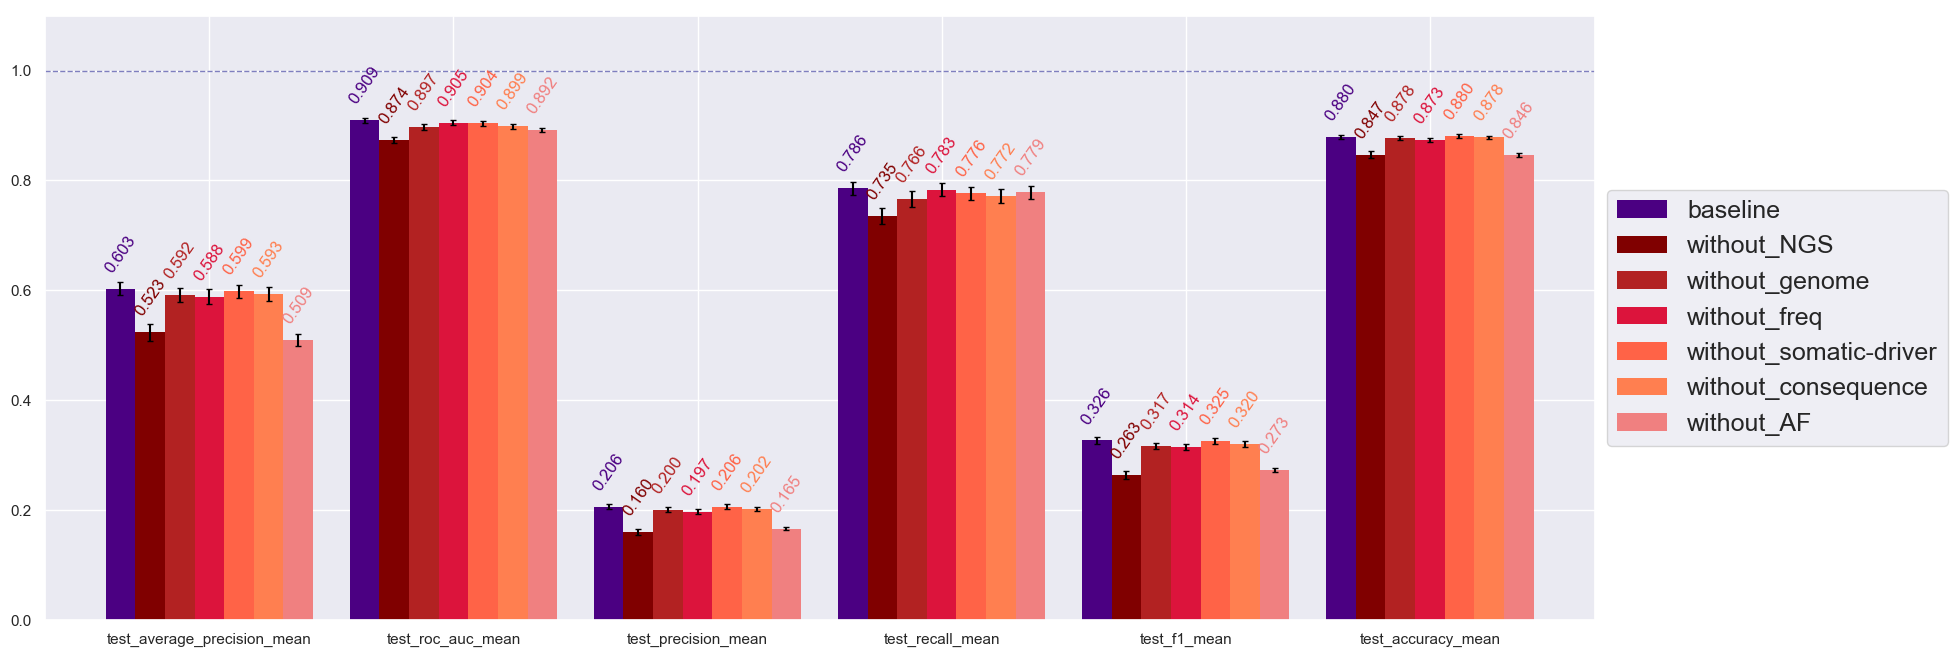

In [157]:
# create summary
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'indigo')

# fill summary
for key, color in zip(job_list, ['maroon', 'firebrick', 'crimson', 'tomato', 'coral', 'lightcoral']):
    summary.add(job_list[key].metrics, key, color)

# plot summary
summary.display()
summary.plot()

## Without gnomAD populations

In [143]:
features = get_features(individual_features_to_remove = AF_populations + ['VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_without_gnomAD_populations', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < fe_without_gnomAD_populations >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_gnomAD_populations


<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ script loaded

In [144]:
job = Selene_Job('fe_without_gnomAD_populations', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ job found and reloaded

In [18]:
job.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_without_gnomAD_populations to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1429   203.9KB/s   00:00    
metrics.pkl                                   100%   32MB  14.0MB/s   00:02    
script.ipy                                    100%  828    72.7KB/s   00:00    
X.pkl                                         100%   53MB  13.3MB/s   00:04    
y.pkl                                         100% 3225KB  15.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_gnomAD_populations
Job <28977502> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_gnomAD_populations -We 59 -n 20 -R "span[ptile=5]" "ipython 

<span style="color:green">Job < fe_without_gnomAD_populations >: </span>✅ submitted<br>

In [158]:
job.get_results()

<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_Kaviar_AF to ../ssh_remote_jobs/job_fe_without_Kaviar_AF
metrics.pkl                                   100%   64MB   9.8MB/s   00:06    
job_output.txt                                100% 1520   458.9KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.326,0.88
fe_without_Kaviar_AF,0.602,0.909,0.205,0.785,0.325,0.879


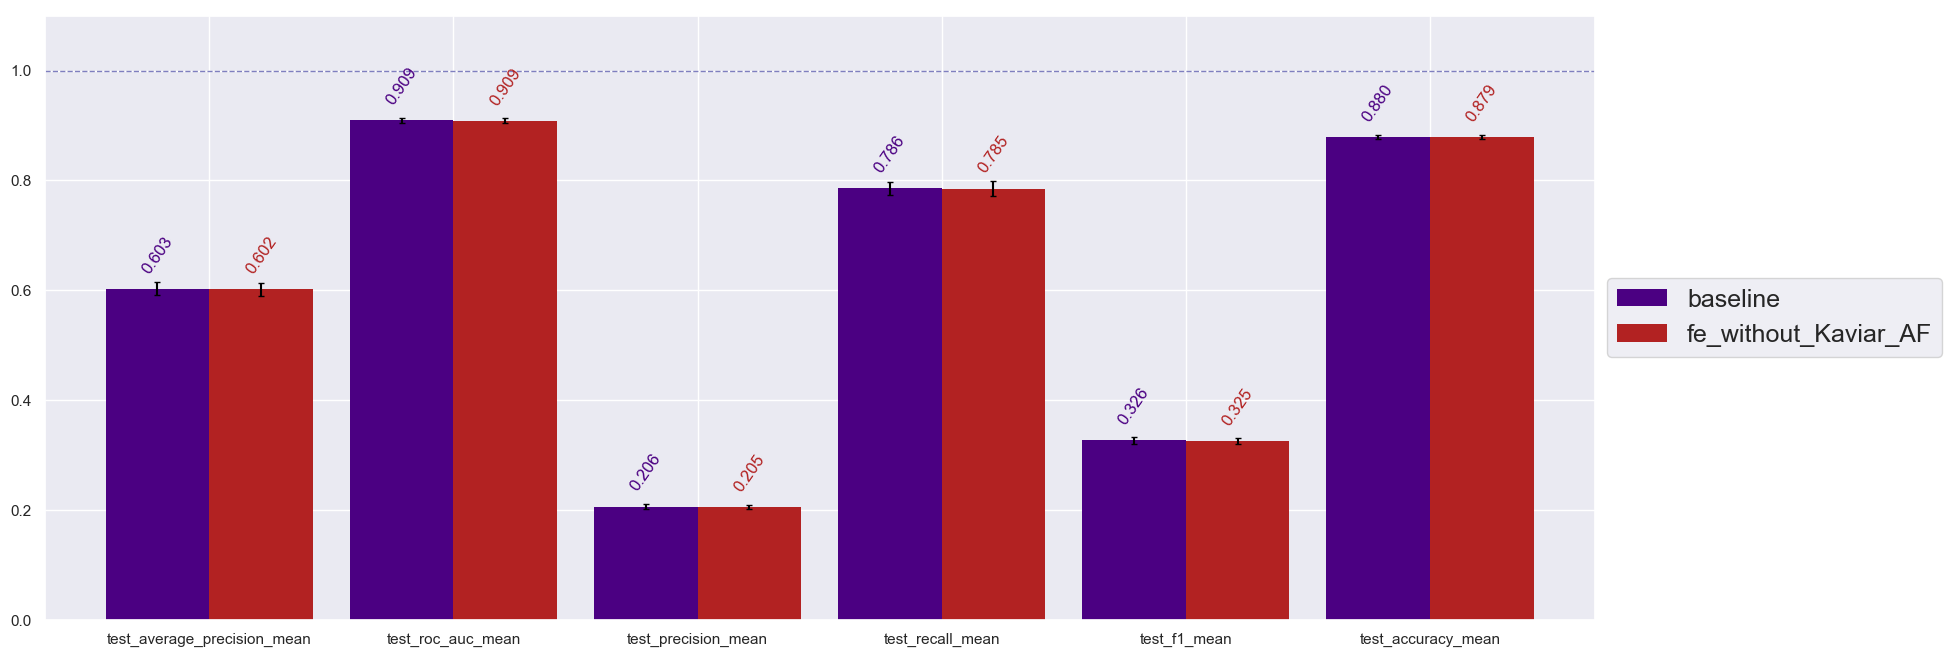

In [159]:
summary_2 = Summary()
summary_2.add(job_baseline.metrics, 'baseline', 'indigo')
summary_2.add(job.metrics, job.job_id, 'firebrick')
summary_2.display()
summary_2.plot()

## Without `Kaviar_AF`

In [154]:
features = get_features(individual_features_to_remove = ['Kaviar_AF', 'VEP_SYMBOL'])
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_without_Kaviar_AF', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < fe_without_Kaviar_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_without_Kaviar_AF


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_without_Kaviar_AF


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ script loaded

In [184]:
job = Selene_Job('fe_without_Kaviar_AF', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ job found and reloaded

In [18]:
job.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_without_Kaviar_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  828    91.1KB/s   00:00    
X.pkl                                         100%   62MB  15.7MB/s   00:03    
y.pkl                                         100% 3225KB  13.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_Kaviar_AF
Job <28990843> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_without_Kaviar_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ submitted<br>

In [185]:
job.get_results()

<span style="color:green">Job < fe_without_Kaviar_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_without_Kaviar_AF to ../ssh_remote_jobs/job_fe_without_Kaviar_AF
metrics.pkl                                   100%   64MB   9.5MB/s   00:06    
job_output.txt                                100% 1520   504.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.326,0.88
fe_without_Kaviar_AF,0.602,0.909,0.205,0.785,0.325,0.879


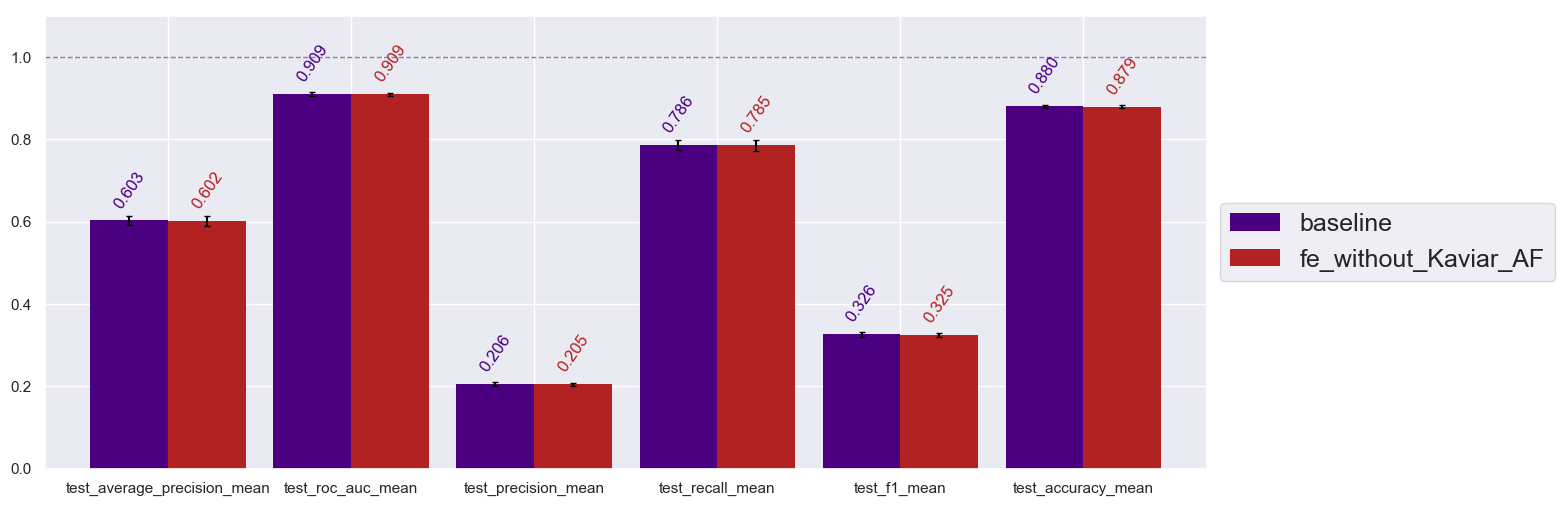

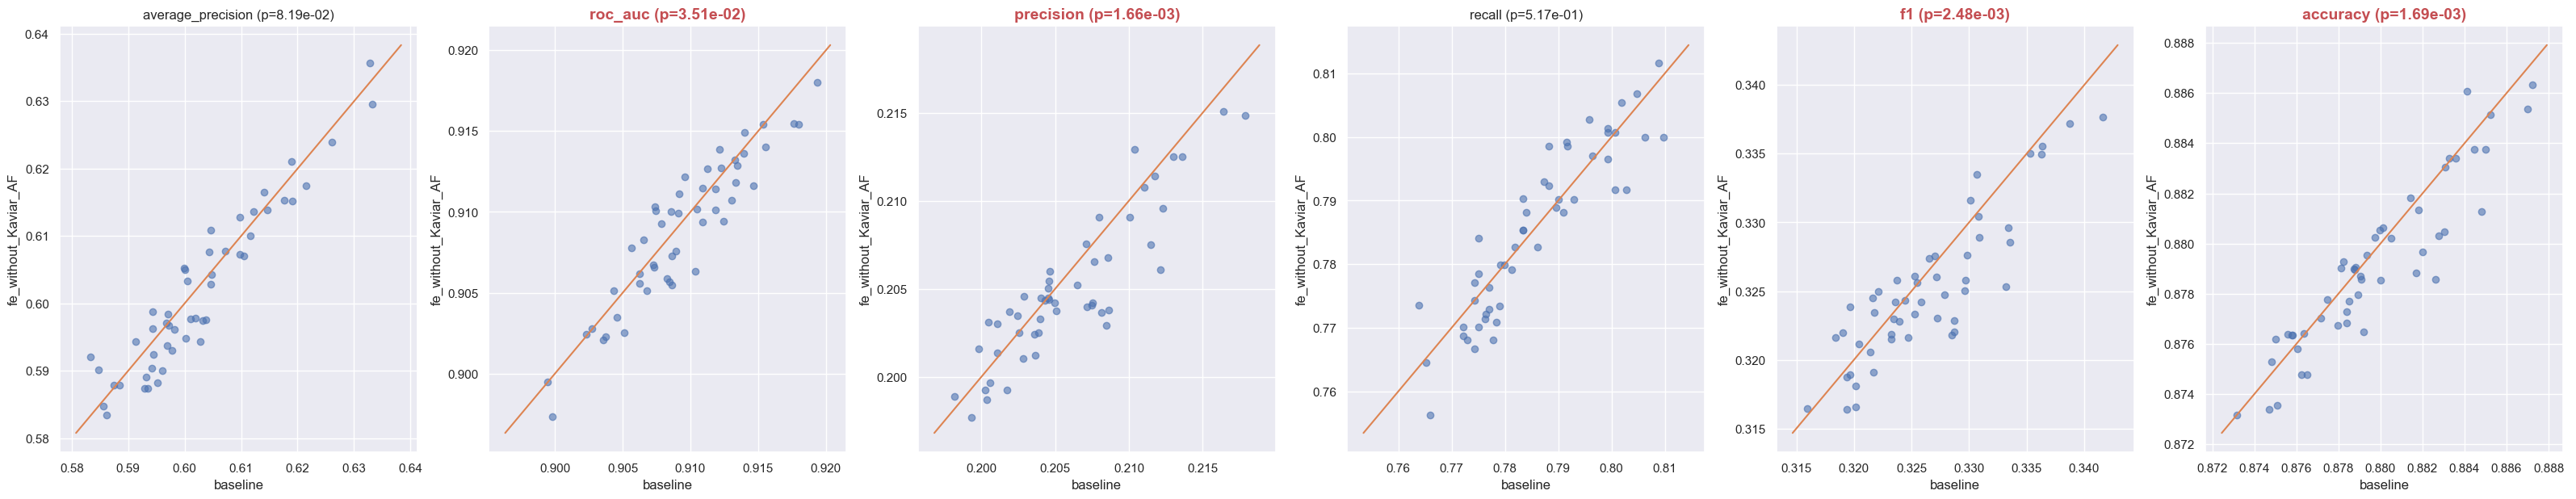

In [188]:
summary_3 = Summary()
summary_3.add(job_baseline.metrics, 'baseline', 'indigo')
summary_3.add(job.metrics, job.job_id, 'firebrick')
summary_3.display()
summary_3.plot(figsize=(15, 6))
summary_3.plot_2_vs_2('baseline', job.job_id)

## New features

### Number of non-null gnomAD population

In [162]:
dd = data.impact.apply(lambda x: sum(x[AF_populations] != 0), axis=1)
get_table(dd)

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [166]:
data.add_features('VEP_gnomAD_non_null_population_number', dd, False)

In [171]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL']) + ['VEP_gnomAD_non_null_population_number']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_with_population_number', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ../ssh_remote_jobs/job_fe_with_population_number


<span style="color:green">Job < fe_with_population_number >: </span>✅ created

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_with_population_number


<span style="color:green">Job < fe_with_population_number >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_with_population_number


<span style="color:green">Job < fe_with_population_number >: </span>✅ script loaded

In [172]:
job = Selene_Job('fe_with_population_number', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_with_population_number >: </span>✅ job found and reloaded

In [173]:
job.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_with_population_number to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  841   137.0KB/s   00:00    
X.pkl                                         100%   65MB  16.3MB/s   00:04    
y.pkl                                         100% 3225KB  12.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_with_population_number
Job <28994466> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_with_population_number -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_with_population_number >: </span>✅ submitted<br>

In [174]:
job.get_results()

<span style="color:red">Job < fe_with_population_number >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.326,0.88
fe_without_Kaviar_AF,0.602,0.909,0.205,0.785,0.325,0.879


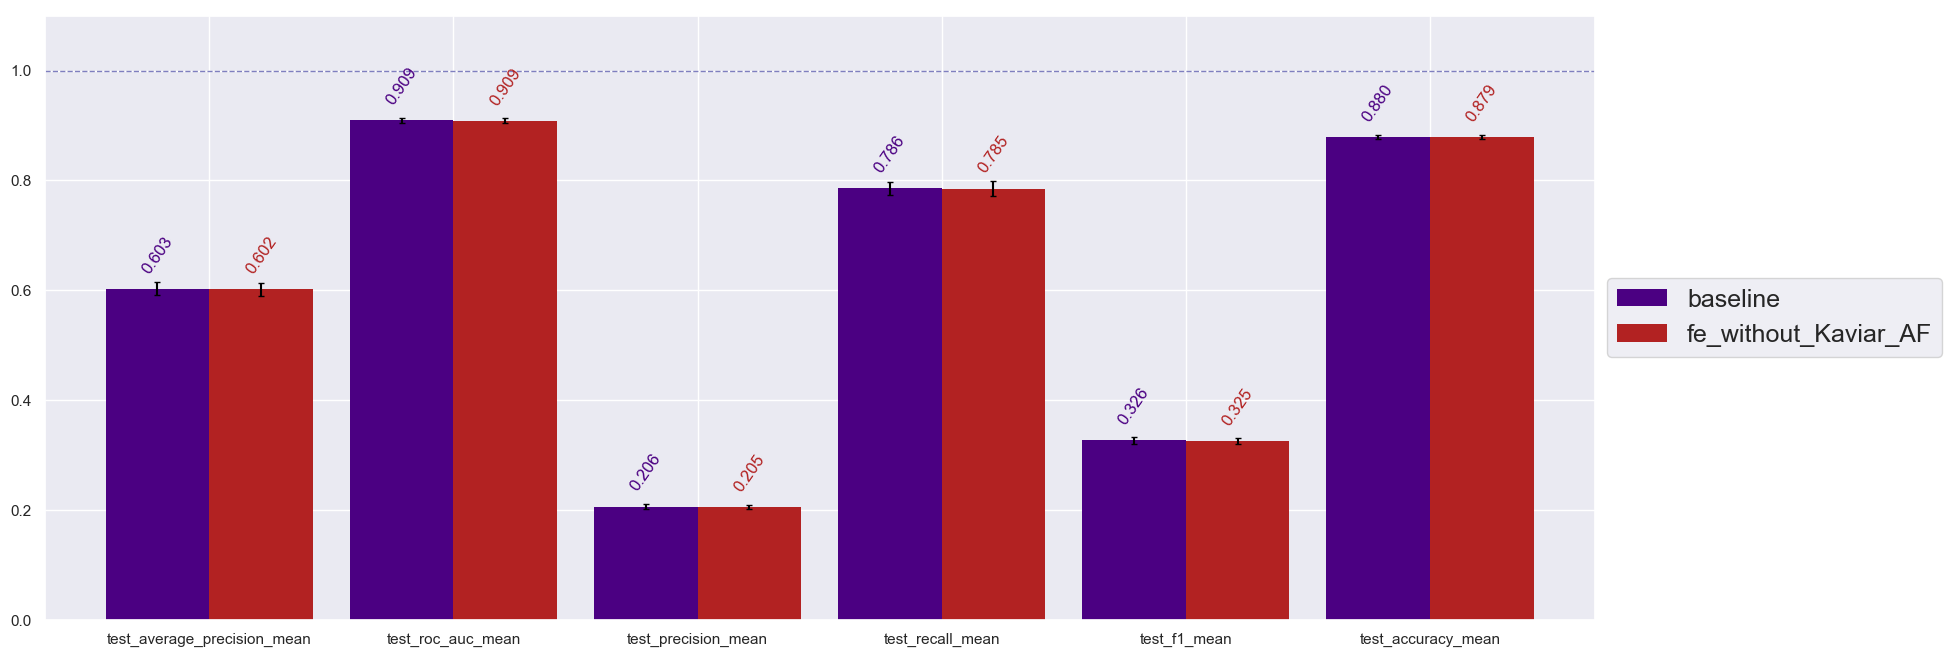

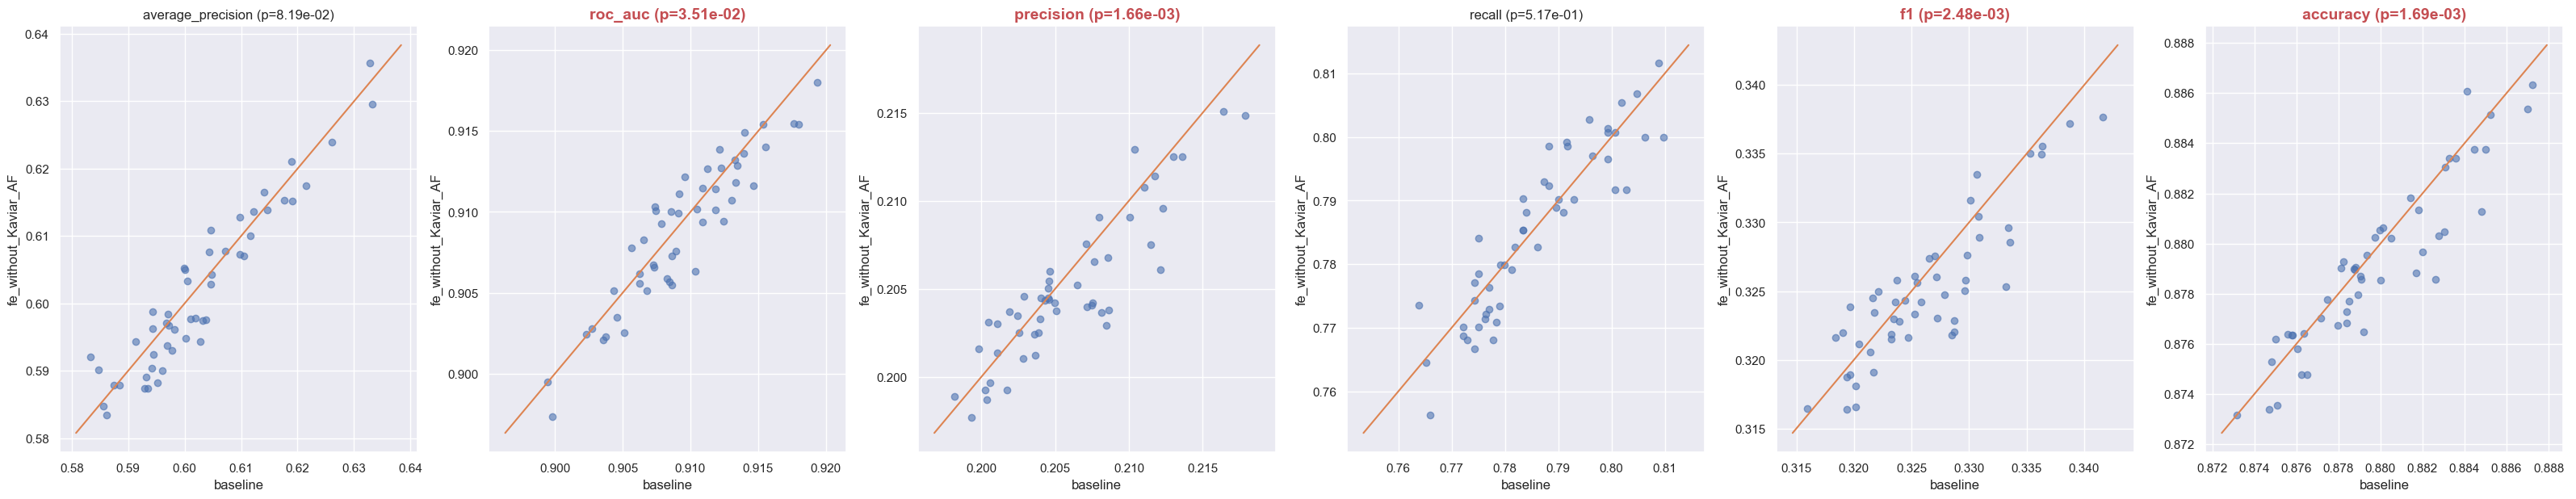

In [160]:
summary_4 = Summary()
summary_4.add(job_baseline.metrics, 'baseline', 'indigo')
summary_4.add(job.metrics, job.job_id, 'firebrick')
summary_4.display()
summary_4.plot(figsize=(15, 6))
summary_4.plot_2_vs_2('baseline', job.job_id)

### Strand ratio

In [175]:
dd = data.impact[['t_alt_neg_count', 't_alt_plus_count']].min(axis=1) / data.impact[['t_alt_neg_count', 't_alt_plus_count']].max(axis=1)
dd.head()

0    0.853448
1    0.884615
2    0.825175
3    0.892857
4    0.886364
dtype: float64

In [176]:
data.add_features('strand_ratio', dd, False)

In [177]:
features = get_features(individual_features_to_remove = ['VEP_SYMBOL']) + ['strand_ratio']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_with_strand_ratio', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')
job.load_data(X, y, path_to_script=job_baseline.script_path)

➞ mkdir on local computer ../ssh_remote_jobs/job_fe_with_strand_ratio


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ created

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_with_strand_ratio


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_with_strand_ratio


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ script loaded

In [178]:
job = Selene_Job('fe_with_strand_ratio', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ job found and reloaded

In [179]:
job.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_with_strand_ratio to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  841   103.5KB/s   00:00    
X.pkl                                         100%   65MB  13.0MB/s   00:05    
y.pkl                                         100% 3225KB  14.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_with_strand_ratio
Job <28994480> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_with_strand_ratio -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_with_strand_ratio >: </span>✅ submitted<br>

In [180]:
job.get_results()

<span style="color:red">Job < fe_with_strand_ratio >: </span>⚠️ does not exist on the cluster, is not done yet or an error occured before the creation of `metrics.pkl`<br>

,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.326,0.88
fe_without_Kaviar_AF,0.602,0.909,0.205,0.785,0.325,0.879


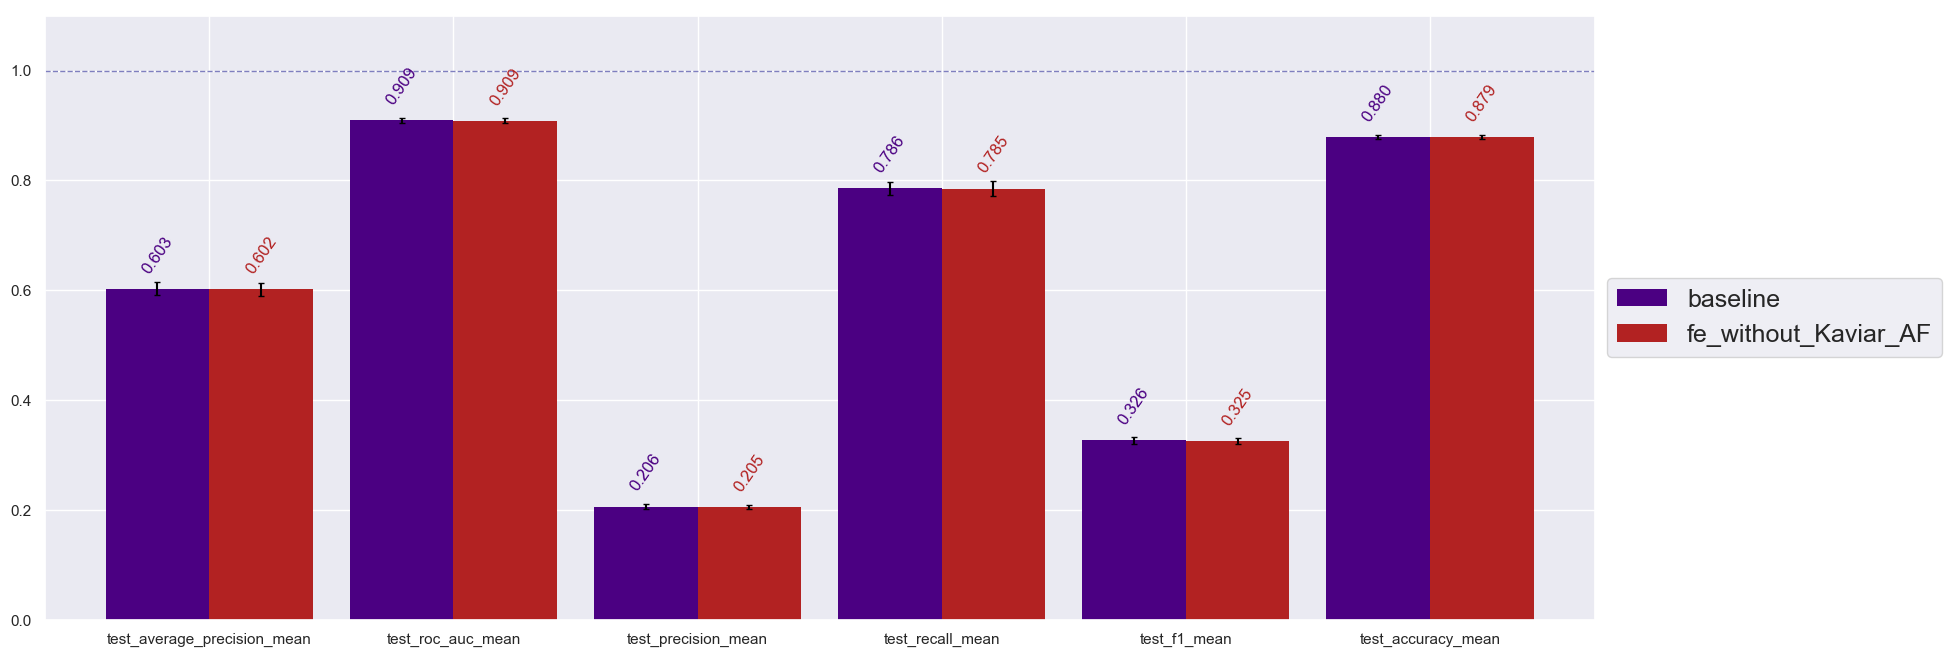

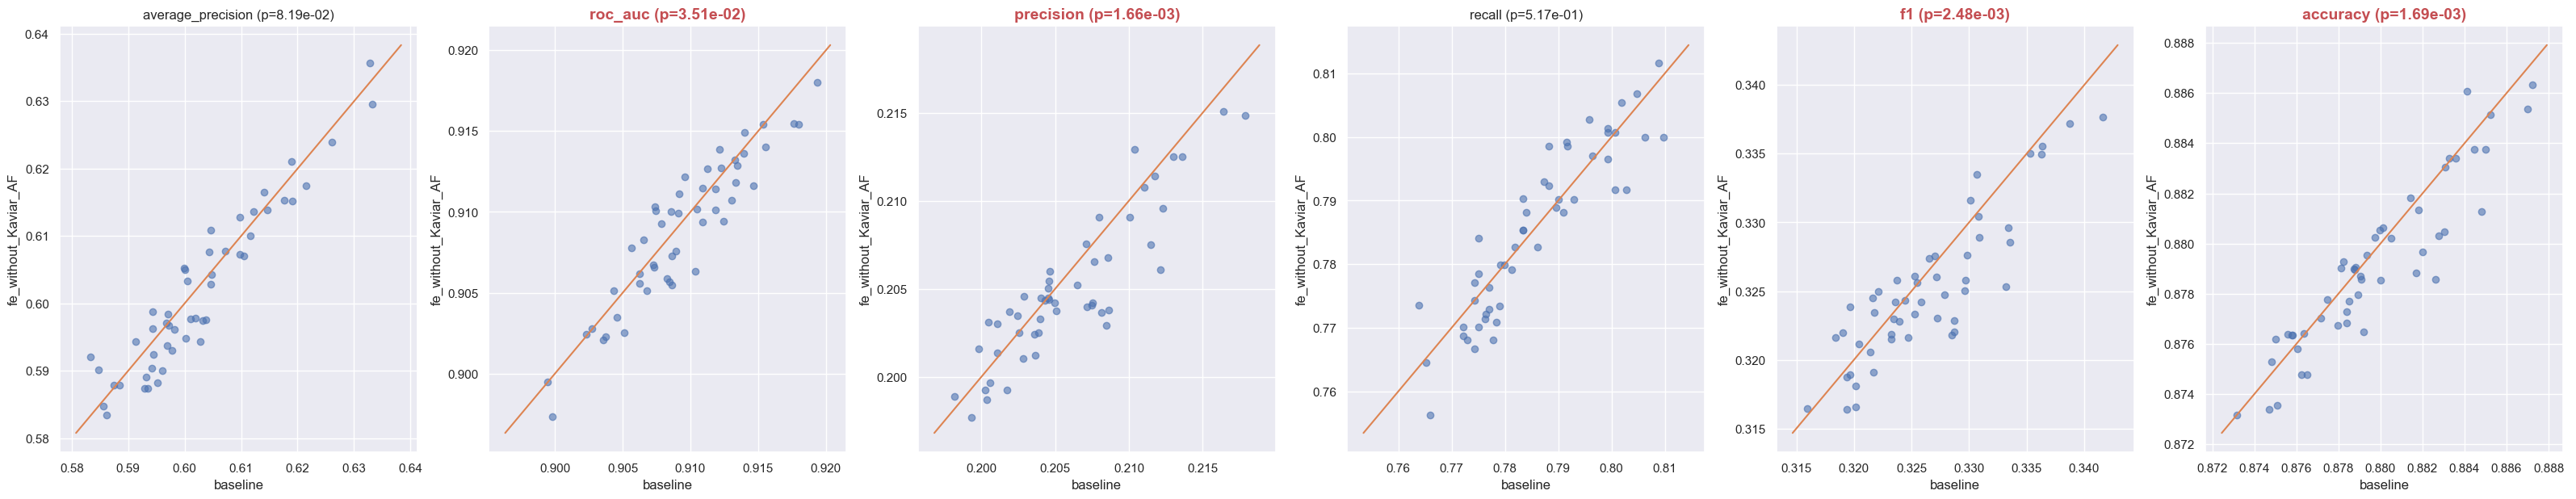

In [160]:
summary_5 = Summary()
summary_5.add(job_baseline.metrics, 'baseline', 'indigo')
summary_5.add(job.metrics, job.job_id, 'firebrick')
summary_5.display()
summary_5.plot(figsize=(15, 6))
summary_5.plot_2_vs_2('baseline', job.job_id)

## VEP gnomAD_AF vs Pierre gnomAD_AF vs both

In [77]:
%run ../selene_job.ipy

In [79]:
# VEP gnomAD_AF
job_1 = Selene_Job('fe_VEP_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

features = get_features(individual_features_to_remove = ['VEP_gnomAD_total_AF', 'VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

job_1.load_data(X, y, path_to_script=job_baseline.script_path)

# Pierre gnomAD_AF
job_2 = Selene_Job('fe_Pierre_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

features = get_features(individual_features_to_remove = ['VEP_gnomAD_AF', 'VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

job_2.load_data(X, y, path_to_script=job_baseline.script_path)

# without
job_3 = Selene_Job('fe_no_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs')

features = get_features(individual_features_to_remove = ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF', 'VEP_SYMBOL'])
data.process(features)
X, y = data.get_X_and_y('all', 'all')

job_3.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < fe_VEP_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_VEP_gnomAD_AF


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_VEP_gnomAD_AF


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ script loaded

<span style="color:red">Job < fe_Pierre_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_Pierre_gnomAD_AF


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_Pierre_gnomAD_AF


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ script loaded

<span style="color:red">Job < fe_no_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_fe_no_gnomAD_AF


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ../ssh_remote_jobs/job_fe_baseline/script.ipy to ../ssh_remote_jobs/job_fe_no_gnomAD_AF


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ script loaded

In [78]:
job_1 = Selene_Job('fe_VEP_gnomAD_AF'   , 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job_2 = Selene_Job('fe_Pierre_gnomAD_AF', 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)
job_2 = Selene_Job('fe_no_gnomAD_AF'    , 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True)

<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ job found and reloaded

In [32]:
job_1.run(n_jobs=20, short_job=True)
job_2.run(n_jobs=20, short_job=True)
job_3.run(n_jobs=20, short_job=True)

➞ scp ../ssh_remote_jobs/job_fe_VEP_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  828   108.8KB/s   00:00    
X.pkl                                         100%   62MB  15.5MB/s   00:04    
y.pkl                                         100% 3225KB  16.8MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_VEP_gnomAD_AF
Job <28990944> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_VEP_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_fe_Pierre_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  828     0.8KB/s   00:01    
X.pkl                                         100%   62MB  15.5MB/s   00:04    
y.pkl                                         100% 3225KB  14.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_Pierre_gnomAD_AF
Job <28990948> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_Pierre_gnomAD_AF -We 59 -n 20 -R "span[ptile=5]" "ipython script.ipy"


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ submitted<br>

In [73]:
job_1.get_results()
job_2.get_results()
job_3.get_results()

<span style="color:green">Job < fe_VEP_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_VEP_gnomAD_AF to ../ssh_remote_jobs/job_fe_VEP_gnomAD_AF
metrics.pkl                                   100%   64MB   9.7MB/s   00:06    
job_output.txt                                100% 1510   368.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


<span style="color:green">Job < fe_Pierre_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_Pierre_gnomAD_AF to ../ssh_remote_jobs/job_fe_Pierre_gnomAD_AF
metrics.pkl                                   100%   64MB   9.6MB/s   00:06    
job_output.txt                                100% 1518   390.6KB/s   00:00    
➞ load metrics.pkl in object self.metrics


<span style="color:green">Job < fe_no_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_fe_no_gnomAD_AF to ../ssh_remote_jobs/job_fe_no_gnomAD_AF
metrics.pkl                                   100%   64MB   9.4MB/s   00:06    
job_output.txt                                100% 1505   139.8KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.603,0.909,0.206,0.786,0.326,0.88
with VEP gnomAD_AF,0.603,0.909,0.206,0.787,0.326,0.88
with Pierre gnomAD_AF,0.603,0.91,0.206,0.786,0.327,0.88
no gnomAD_AF,0.603,0.909,0.205,0.785,0.326,0.879


<Figure size 432x288 with 0 Axes>

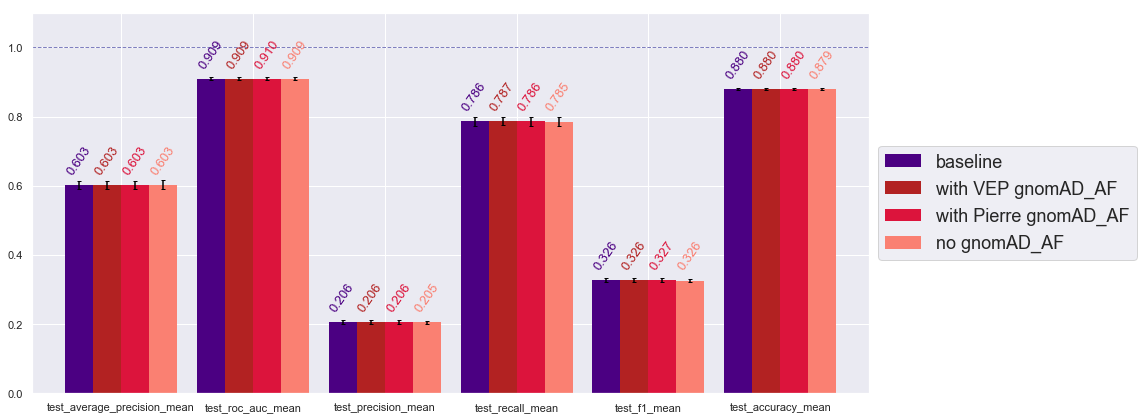

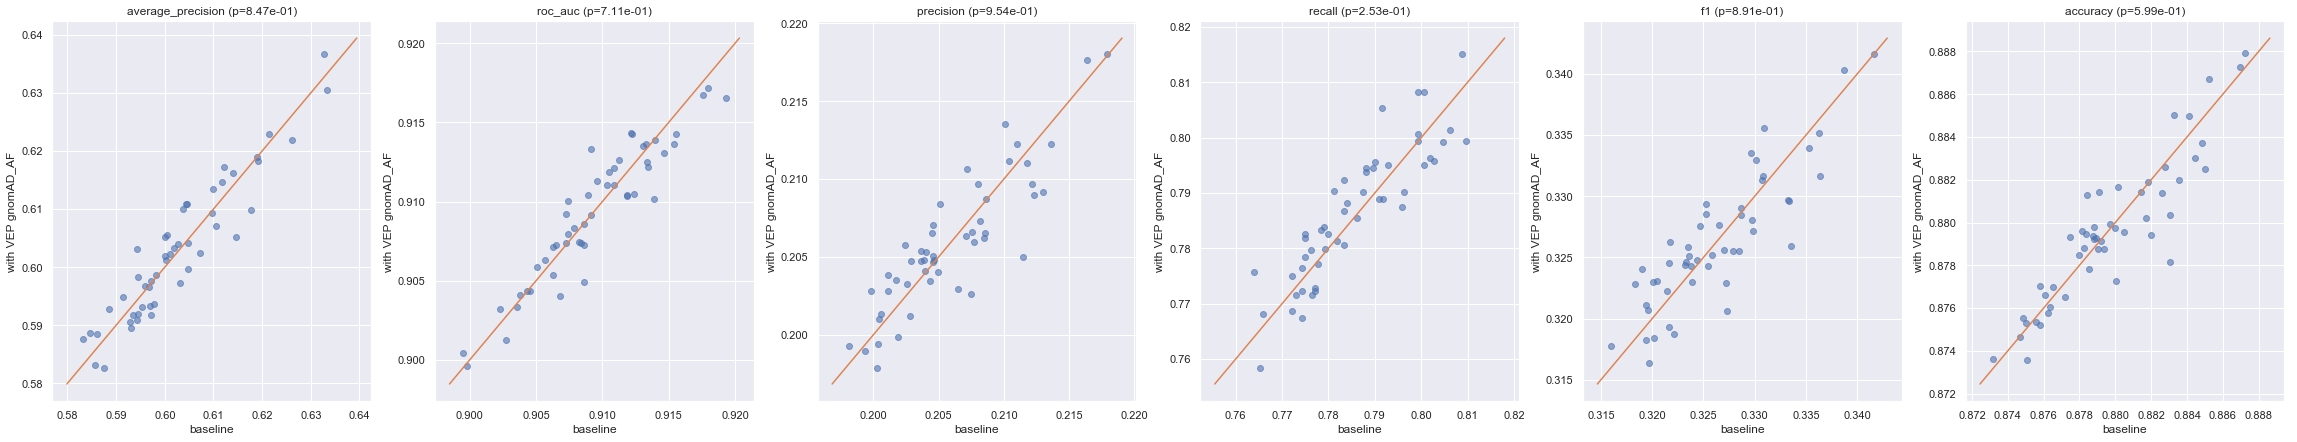

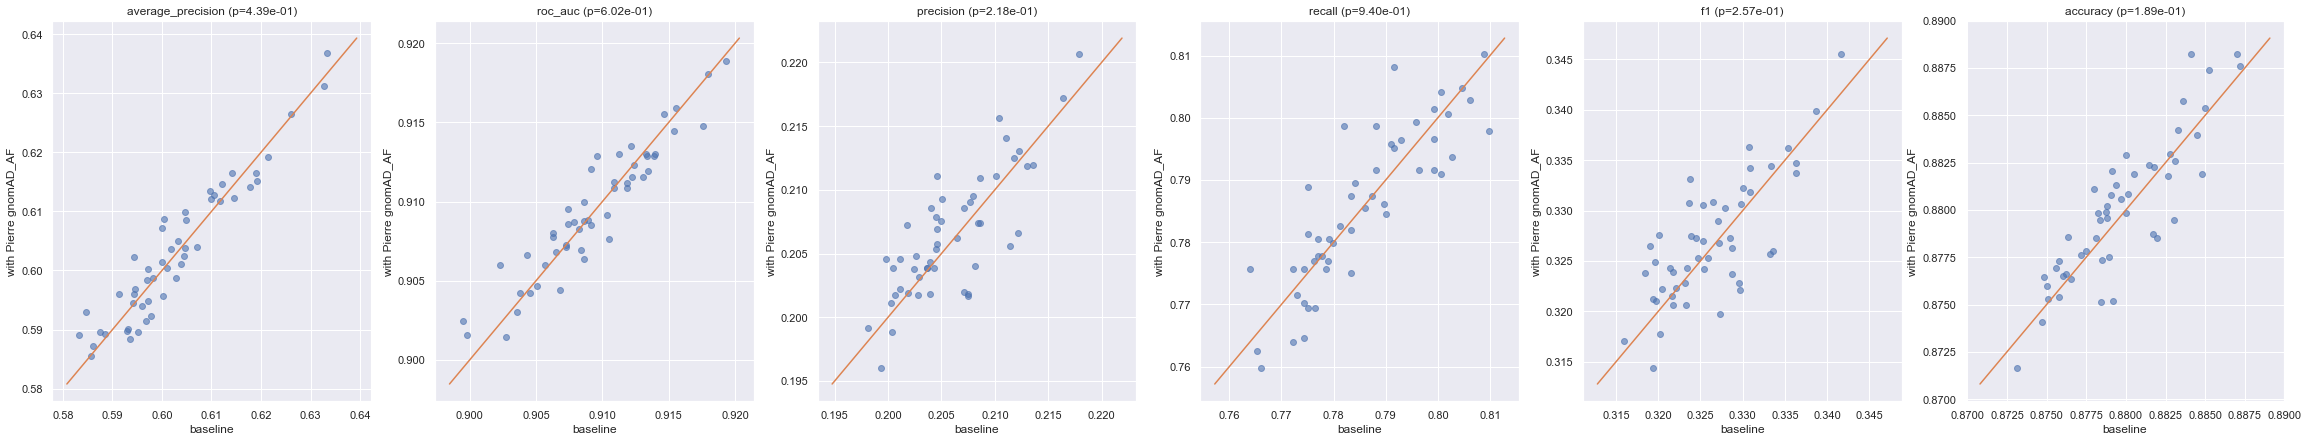

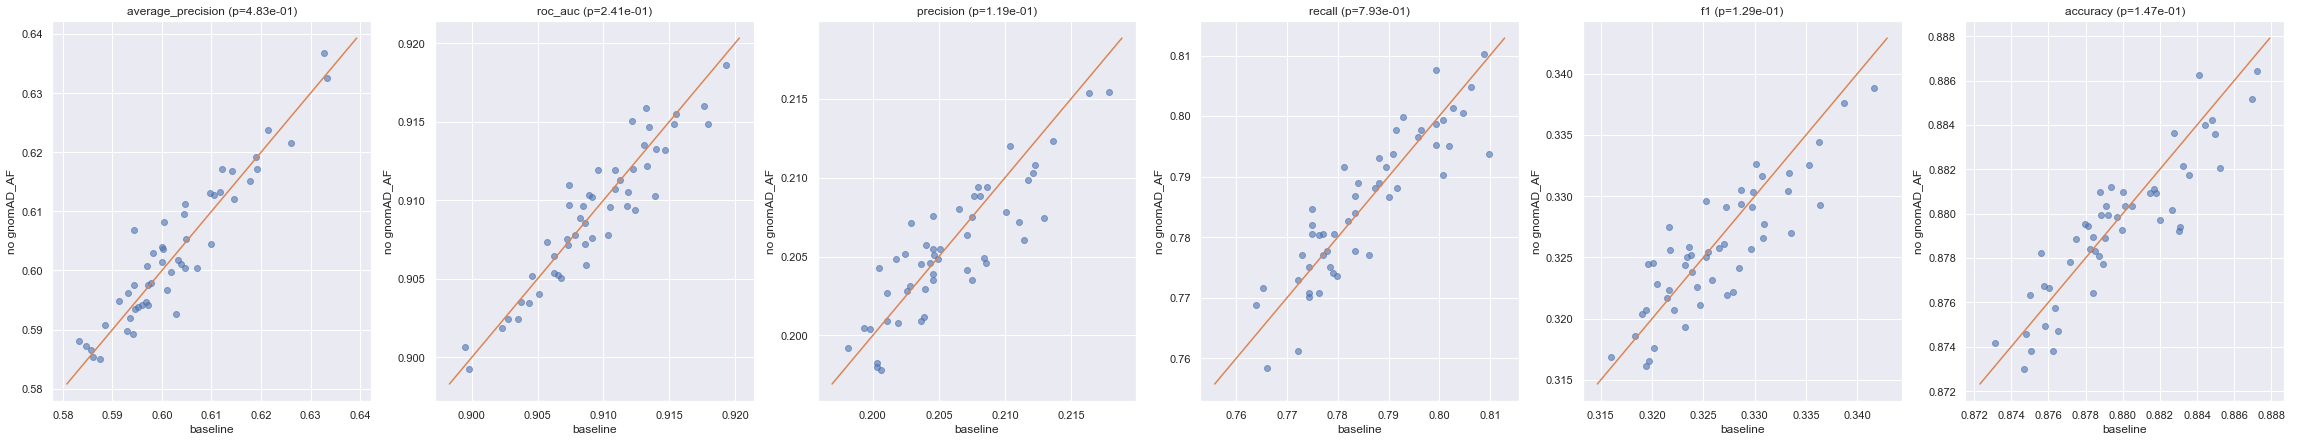

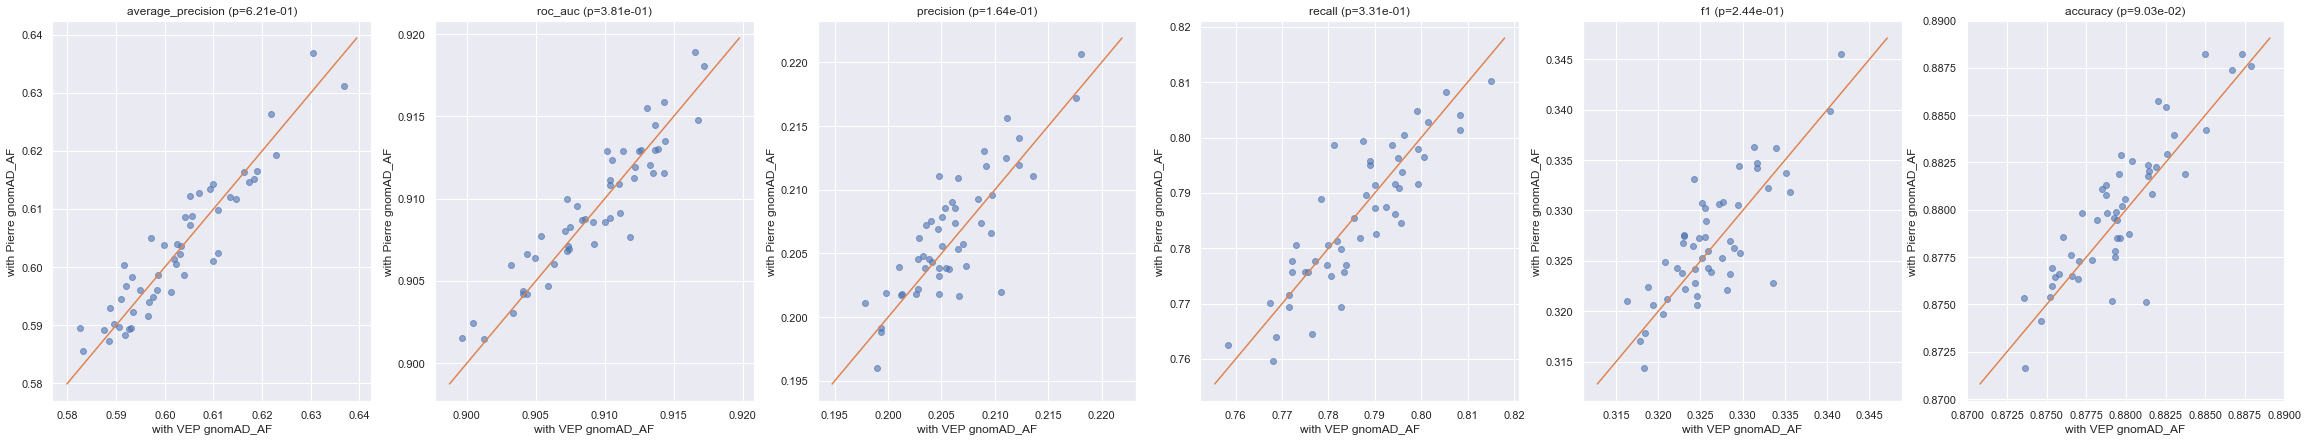

In [75]:
%run ../summary.py
# create summary
summary_4 = Summary()

# fill summary
summary_4.add(job_baseline.metrics, 'baseline', 'indigo')
summary_4.add(job_1.metrics, 'with VEP gnomAD_AF', 'firebrick')
summary_4.add(job_2.metrics, 'with Pierre gnomAD_AF', 'crimson')
summary_4.add(job_3.metrics, 'no gnomAD_AF', 'salmon')

# plot summary
summary_4.display()
summary_4.plot(figsize=(15, 7), fontsize=13)
summary_4.plot_2_vs_2('baseline', 'with VEP gnomAD_AF')
summary_4.plot_2_vs_2('baseline', 'with Pierre gnomAD_AF')
summary_4.plot_2_vs_2('baseline', 'no gnomAD_AF')
summary_4.plot_2_vs_2('with VEP gnomAD_AF', 'with Pierre gnomAD_AF')